# Graph Dataset Loading and Batching
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


*Need to implement*: `raw_i` $\mapsto$ `Data()`$\mapsto$ `Dataset.process()` $\mapsto$`processed` dir (save processed graphs).

$$T_{edge:(i,j)} = \Lambda_{ij}(t)+\sum_{k\in\{cells\ for\ (i,j)\}}K_p^{(k)}(p^{(k)}-p_0^{(k)})$$
$$\pi_{cell:k} = -2K_a^{(k)}(a^{(k)}-a_0^{(k)})$$

## Working with PyTorch Geometric

`torch_geometric.data.Data` attributes:
- `.x` : node features `[num_nodes, num_node_features]`
- `.edge_index` : edges as \[source, target\] node index pairs (COO format) with shape `[2, num_edges]` and `torch.long` type (int).
- `.edge_attr`: edge features with shape `[num_edges, num_edge_features]`
- `.y` : target, arbitrary shape, if node-level target then `[num_nodes, *]`, or graph-level target `[1, *]`
- `.pos`: node positions `[num_nodes, num_dims]`.
- can add additional attributes, e.g. "cells"

- **Node features** : velocities from previous frames (~ 5 frames--> Alvaro Sanchez-Gonzalez, *et al.* 2020 \[ASG2020\])
- **Edge features** : can use edge directions (optional, might help to speed up training)
- **Current position** : technically a node feature, and needs to be normalized but not processed by the network.
- Positions (Cartesian) to polar edge attributes: `transforms.Polar` \[[link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.Polar)\], I can also implement or use the `transforms.Cartesian` which computes direction vectors (position pairs -to- normalized direction vectors).
- need transform for velocity noise (use src from example transforms above and ASG2020 paper)
- Trail movie: max edge length ~ 3.25 a.u.

In [4]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

In [6]:
from simgnn.datasets import VertexDynamics, CellData

In [14]:
num_nodes=4
num_cells=2 #{0:[0,1,2], 1:[1,2,3]}
edge_index = torch.tensor([[0,0,1,1,1,2,2,2,3,3],
                           [1,2,2,0,3,0,1,3,1,2]])
node2cell_index = torch.tensor([[0,1,2,1,2,3],
                                [0,0,0,1,1,1]])
cell2node_index = torch.tensor([[0,0,0,1,1,1],
                                [0,1,2,1,2,3]])
x = torch.randn(num_nodes, 5)
y = torch.randn(num_nodes, 3)
y_edge = torch.randn(edge_index.size(1)//2, 2)
data = CellData(num_nodes=num_nodes,
                num_cells=num_cells,
                edge_index=edge_index,
                node2cell_index=node2cell_index,
                cell2node_index=cell2node_index,
                x=x, y=y, y_edge=y_edge
               )
print(data)
print(data.edge_index)

CellData(cell2node_index=[2, 6], edge_index=[2, 10], node2cell_index=[2, 6], x=[4, 5], y=[4, 3], y_edge=[5, 2])
tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3],
        [1, 2, 2, 0, 3, 0, 1, 3, 1, 2]])


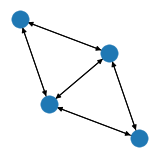

In [15]:
plt.figure(figsize=[2,2])
nx.draw(to_networkx(data))

Batch(batch=[8], cell2node_index=[2, 12], edge_index=[2, 20], node2cell_index=[2, 12], x=[8, 5], y=[8, 3], y_edge=[10, 2])


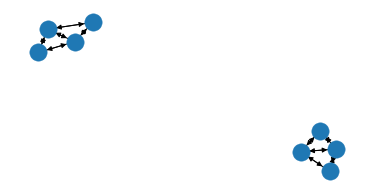

In [17]:
data_list = [data, data]
loader = DataLoader(data_list, batch_size=2)
batch = next(iter(loader))
print(batch)
plt.figure(figsize=[5,2.5])
nx.draw(to_networkx(batch))

- `simgnn.datasets.VertexDynamics` (child of `torch_geometric.data.Dataset`)

In [25]:
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data')
vtxdata

VertexDynamics(95)

In [21]:
# t=5
# Dt = 1
# # plt.figure(figsize=[25,25])
# nx.draw(to_networkx(vtxdata[t], to_undirected=True),pos=dict(enumerate(vtxdata[t].pos.numpy())), node_size=60)
# nx.draw(to_networkx(vtxdata[t+Dt], to_undirected=True),pos=dict(enumerate(vtxdata[t+Dt].pos.numpy())),
#         node_size=20,width=4,
#         node_color='#FF00FF',edge_color='#51C5FF',alpha=.5)
# plt.quiver(vtxdata[t].pos.numpy()[:,0], vtxdata[t].pos.numpy()[:,1],
#            vtxdata[t].y.numpy()[:,0],vtxdata[t].y.numpy()[:,1],
#            units='xy',angles='xy',scale=.25,color='r')

In [24]:
# Compare computed and original *edge lengths*
# dist_fn = T.Distance(norm=False)
# compute cartesian distances
# dist_fn(data);

# GCN tutorial

In [40]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
print('#datasets:',len(dataset),'\n1st:',dataset[0],'\nName:',dataset)

# 2-layer GCN
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print('Training 2-layer GCN.')
tot_epoch = 200
print_freq = tot_epoch//5
for epoch in range(tot_epoch):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if (epoch+1)%print_freq==0:
        model.eval()
        with torch.no_grad():
            _, pred = model(data).max(dim=1)
            correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            print('Epoch {:5}| Accuracy: {:4.2f}% |'.format(epoch,100*correct / int(data.test_mask.sum())))

model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

#datasets: 1 
1st: Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708]) 
Name: Cora()
Training 2-layer GCN.
Epoch    39| Accuracy: 78.30% |
Epoch    79| Accuracy: 79.60% |
Epoch   119| Accuracy: 79.30% |
Epoch   159| Accuracy: 79.50% |
Epoch   199| Accuracy: 80.40% |
Accuracy: 0.8040


# Working with the Raw data (for Debugging Dataset)

## Set Raw Dataset location

In [18]:
data_root = '../../../dataDIR/simgnn_data/raw'# location of all datasets
raw_path = path.join(data_root,'17Nov2020')

In [19]:
!ls $raw_path

graph_dict.pkl	simul_Ka.npy	     simul_Length.npy	  simul_t.npy
simul_A0.npy	simul_Kp.npy	     simul_P0.npy	  simul_vtxpos.npy
simul_Area.npy	simul_Lambda_ij.npy  simul_Perimeter.npy  t_Energy_maxSpeed.npy


## Loading and Working with Dataset(s)

Representation of cells in the monolayer graph:
- dict of lists with cell numbers $0, 1, \dots N$ as keys, and edges (values).
- edge ind-s **start from 1** in the cells (values), don't forget to **convert** when indexing edges tensor (e.g. `edge_ID=np.abs(ID)-1`). Negative indices indicate reversed order for vertices (cell is defined as a closed region formed by edges connected *end-to-end*). Use `np.sign(cells[c])` to find reversed edges for cell `c`.
    - e.g. get edges of cell `c` : `np.abs(mg_dict['cells'][c])-1` (`mg_dict` is monolayer graph dict loaded with `datautils.load_graph`)

In [20]:
# load dict of monolayer graph
mg_dict = load_graph(path.join(raw_path,'graph_dict.pkl'))

# Load vertex positions from simulation results: Frames x Vertices x Positions
vx_pos = load_array(path.join(raw_path,'simul_vtxpos.npy')) # T x N x 2
vx_vel = np.diff(vx_pos,n=1,axis=0) # T-1 x N x 2

# init-l vertex positions (1st frame)
vx0 = vx_pos[0]

# convert edges list to tensor
edges = torch.tensor(mg_dict['edges'],dtype=torch.long)

In [21]:
edge_lengths = load_array(path.join(raw_path, 'simul_Length.npy'))
Lambda_ij = load_array(path.join(raw_path,'simul_Lambda_ij.npy'))
# assert Lambda_ij.shape[1]!=edges.shape[0]

A0 = load_array(path.join(raw_path, 'simul_A0.npy'))
Area = load_array(path.join(raw_path, 'simul_Area.npy'))
Ka = load_array(path.join(raw_path, 'simul_Ka.npy'))

P0 = load_array(path.join(raw_path, 'simul_P0.npy'))
Perims = load_array(path.join(raw_path, 'simul_Perimeter.npy'))
Kp = load_array(path.join(raw_path, 'simul_Kp.npy'))

In [23]:
mg_dict['cells']

{0: [1, 2, 3, 4, 5, 6],
 1: [7, 8, 9, 10, 11, 12],
 2: [13, 14, 15, 16, 17, 18],
 3: [-15, 19, 20, 21, 7, 22],
 4: [23, 24, 25, 26, 27, 28],
 5: [29, 30, 31, 32, 33, 28],
 6: [34, 35, 36, 37, -18, 38],
 7: [39, 40, 41, 42, 43, 44],
 8: [45, 46, 47, 48, 49, 50],
 9: [50, 51, 52, 26, 53, 54],
 10: [48, 55, 56, 57, 58, 59],
 11: [60, 61, 62, 63, 64, 65],
 12: [-64, 66, 52, -25, 67, 68],
 13: [-63, 69, 70, -45, 51, -66],
 14: [71, 72, 73, 74, 75, 76],
 15: [77, 78, 79, 80, 81, 82],
 16: [82, 83, 84, 85, 86, 87],
 17: [88, 89, 90, 91, 92, 93],
 18: [-89, 94, 78, 95, 72, 96],
 19: [93, 97, 98, 99, 100, 101],
 20: [88, 94, -77, 83, 102, -97],
 21: [103, 104, 105, 106, 107, 108],
 22: [-106, 109, 110, 37, 13, 111],
 23: [107, 112, 113, -19, -14, 111],
 24: [114, 115, 116, 117, 118, 119],
 25: [-117, 120, 121, 122, -91, 123],
 26: [118, 124, -73, 96, 90, 123],
 27: [116, 120, 125, -31, 126, 127],
 28: [-115, 128, 104, 129, 130, 127],
 29: [131, 132, 133, 134, 135, 136],
 30: [-134, 137, -119, 1

### Pre-processing

In [7]:
window_size = 5
Y_node = vx_vel[window_size:] # Vel[w:]
node_pos = vx_pos[window_size:-1]

# last_index = total_frames - (2+window_size)
# num_of_features = last_index+1
X_node = np.stack([ vx_vel[k:k+window_size].transpose((1,0,2))
                    for k in range(vx_pos.shape[0]-(2+window_size)+1)])

print(f'node_pos:{node_pos.shape} (T+0 pos-n)')
print(f'node_features:{X_node.shape} ([T-1:T-window_size] vel-s)\n-'+5*' -'+' -')
print(f'Y_node : {Y_node.shape} (T+0 vel-y)')
# node_pos[0] = vx_pos[window_size] ; node_pos[-1] = vx_pos[-2]
# =>vx_pos[-1]=node_pos[-1]+Y_node[-1]
# node_next = vx_pos[window_size+1:]
# assert np.sum(np.abs(Y_node+node_pos-node_next)) == 0
#
# assert np.sum(np.abs(X_node[0][:,-1,:]-vx_vel[4])) ==0

node_pos:(95, 240, 2) (T+0 pos-n)
node_features:(95, 240, 5, 2) ([T-1:T-window_size] vel-s)
- - - - - - -
Y_node : (95, 240, 2) (T+0 vel-y)


### Visualising Var-s and Intermediate Results

In [8]:
# t = 13
# plt.quiver(vx_pos[t,:,0],vx_pos[t,:,1], vx_vel[t,:,0], vx_vel[t,:,1],units='xy',angles='xy',scale=.1)
# plt.plot(vx_pos[t,:,0],vx_pos[t,:,1],'ro',alpha=.5)
# plt.plot(vx_pos[t+1,:,0],vx_pos[t+1,:,1],'bo',alpha=.3)

In [10]:
# edge_lengths.max()
# plt.hist(Perims.ravel(),bins=100);

In [11]:
# plt.hist(Area.ravel(),bins=100);

In [12]:
# plt.hist((edge_lengths.ravel()), bins=50, density=True);
# plt.xlabel('Edge Lengths (a.u.)')
# plt.ylabel('Frequency (normalised)')
# plt.title('10x10 cell monolayer trial with random oscillations\n(17-Nov-2020; 100 sample frames from a movie)')
# plt.savefig('edge_length_17Nov2020.png',dpi=100);

In [13]:
# import networkx as nx
# np.random.seed(42)

# cell_samples = np.random.choice(list(mg_dict['cells'].keys()),10)

# mg_nx = nx.Graph(mg_dict['edges'])
# nx.draw(mg_nx,pos=dict(zip(range(vx0.shape[0]),vx0)),
#         node_size=20,width=4,node_color='#FF00FF',edge_color='#51C5FF')
# for c in cell_samples:
#     c_vxs = vx0[edges[(np.abs(mg_dict['cells'][c])-1)].view(-1,),:]
#     c_loc = c_vxs.mean(axis=0)
#     plt.plot(c_loc[0],c_loc[1],'ro',ms=10)
#     for vx_i in c_vxs:
#         plt.plot([vx_i[0],c_loc[0]], [vx_i[1],c_loc[1]],lw=4)